# Evaluation

In [1]:
import pandas as pd
from plotnine import (
    aes,
    element_text,
    expand_limits,
    facet_grid,
    facet_wrap,
    geom_bar,
    geom_col,
    geom_hline,
    geom_point,
    ggplot,
    guide_legend,
    labs,
    scale_alpha_manual,
    scale_color_manual,
    scale_fill_manual,
    scale_y_continuous,
    theme,
    theme_bw,
    ylim,
)

from config import MAIN_MODELS, MODEL_COLORS, MODEL_NAMES, MODEL_ORDER, ROOT, WIS_ALPHA

In [2]:
def custom_theme():
    return theme(
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8, rotation=90, ha="center", ma="right"),
        axis_text_y=element_text(size=8),
    )

# Prepare scores

In [3]:
def load_scores(filename, by_horizon=False, by_age=False, long_format=False):
    df = pd.read_csv(ROOT / "results" / "scores" / filename)
    df.model = df.model.replace(MODEL_NAMES)

    if "level" in df.columns:
        df["level"] = pd.Categorical(df["level"], categories=["national", "age"], ordered=True)

    if long_format:
        if by_horizon:
            ids = ["level", "horizon", "model"]
        elif by_age:
            ids = ["age_group", "model"]
        else:
            ids = ["level", "model"]

        df = pd.melt(
            df,
            id_vars=ids,
            value_vars=["wis", "underprediction", "spread", "overprediction", "ae"],
            var_name="metric",
            value_name="value",
        )

    return df

# Plots

In [4]:
def plot_total_scores(df_long, models=None):
    if models is not None:
        df_long = df_long[df_long.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in df_long.model.unique()]
    df_long["model"] = pd.Categorical(df_long["model"], categories=model_order, ordered=True)

    p = (
        ggplot()
        + facet_wrap(
            "~level",
            nrow=1,
            scales="free_y",
            labeller=lambda x: ("National level" if x == "national" else "Age groups"),
        )
        + geom_point(
            df_long[df_long.metric == "ae"],
            aes(x="model", y="value", fill="model"),
            shape="D",
            show_legend=False,
        )
        + geom_bar(
            df_long[df_long.metric == "wis"],
            aes(x="model", y="value", color="model"),
            fill="white",
            stat="identity",
            width=0.7,
            show_legend=False,
        )
        + geom_bar(
            df_long[~df_long.metric.isin(["wis", "ae"])],
            aes(x="model", y="value", fill="model", alpha="metric", color="model"),
            size=0.1,
            stat="identity",
            width=0.7,
            show_legend={"color": False, "fill": False, "alpha": True},
        )
        + scale_color_manual(values=MODEL_COLORS)
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_manual(
            values=WIS_ALPHA,
            labels=["Overprediction", "Spread", "Underprediction"],
            guide=guide_legend(reverse=False),
        )
        + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS:", title="")
        + theme_bw()
        + custom_theme()
        + theme(legend_position="right", legend_title_position="top")
    )
    return p

In [5]:
df_long = load_scores("scores.csv", long_format=True)

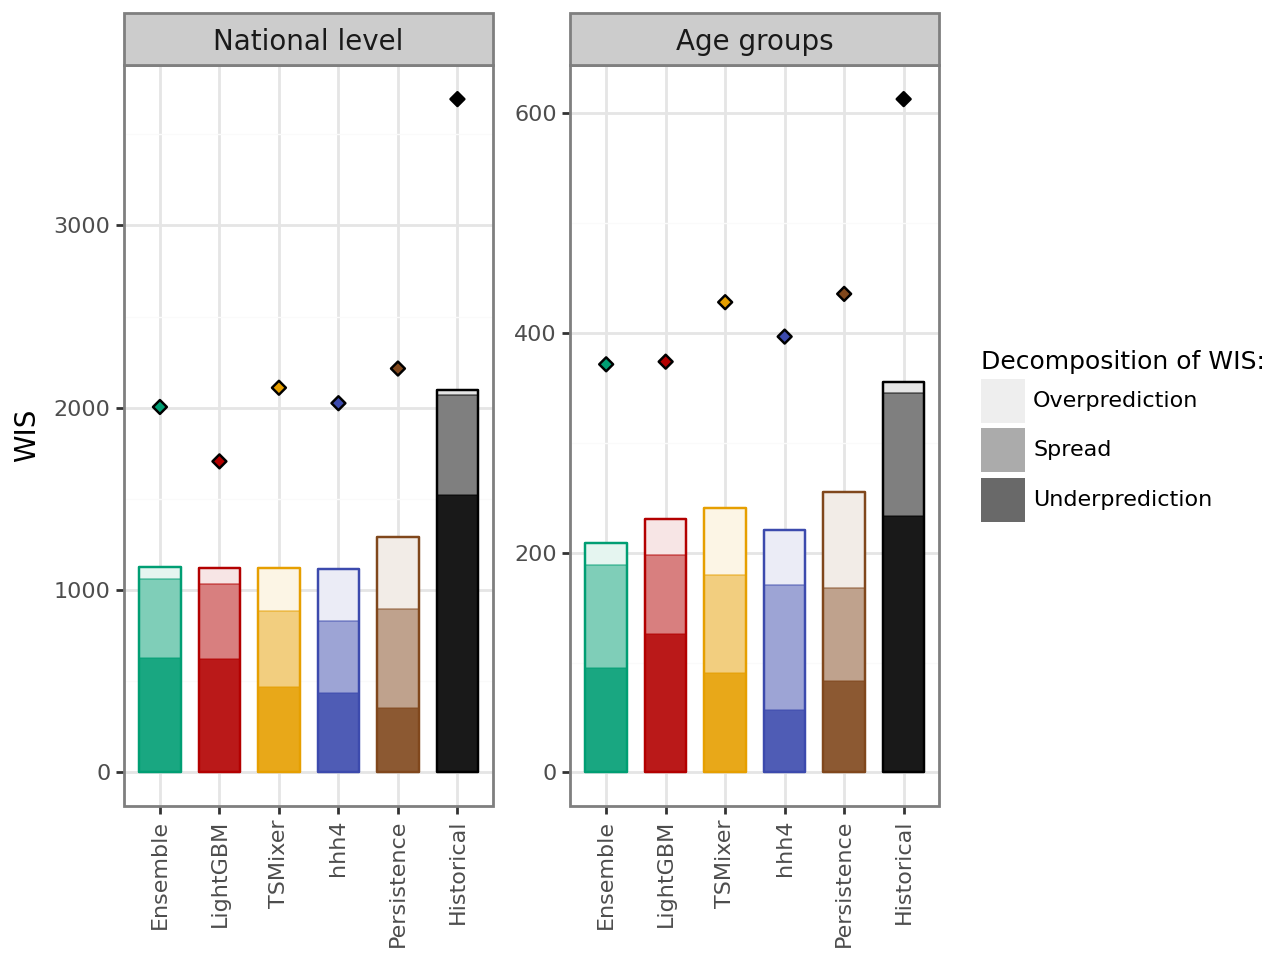

In [6]:
p = plot_total_scores(df_long, models=MAIN_MODELS)
p.show()

In [7]:
p.save(ROOT / "figures" / "wis.pdf", width=160, height=70, units="mm", dpi=600, verbose=False)

In [8]:
def plot_coverage(df_wide, models=None):
    if models is not None:
        df_wide = df_wide[df_wide.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in df_wide.model.unique()]
    df_wide["model"] = pd.Categorical(df_wide["model"], categories=model_order, ordered=True)

    alphas = {"50%": 0.7, "95%": 0.4}

    p = (
        ggplot(df_wide, aes(x="model"))
        + facet_wrap(
            "~level",
            nrow=1,
            scales="fixed",
            labeller=lambda x: ("National level" if x == "national" else "Age groups"),
        )
        + expand_limits(y=1)
        + geom_col(aes(y="c95"), width=0.7, fill="white", show_legend={"fill": False})
        + geom_col(
            aes(y="c95", fill="model", alpha='"95%"'),
            width=0.7,
            show_legend={"fill": False},
        )
        + geom_col(
            aes(y="c50", fill="model", alpha='"50%"'),
            width=0.7,
            show_legend={"fill": False},
        )
        + geom_hline(yintercept=[0.5, 0.95], linetype="dashed")
        + scale_y_continuous(labels=lambda y: ["0" if val == 0 else val for val in y])
        + labs(x="", y="Empirical coverage", color="Model", alpha="Prediction interval: ")
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_manual(values=alphas, guide=guide_legend(reverse=False))
        + theme_bw()
        + custom_theme()
        + theme(legend_position="right", legend_title_position="top", panel_spacing=0.025)
    )

    return p

In [9]:
df_wide = load_scores("scores.csv")

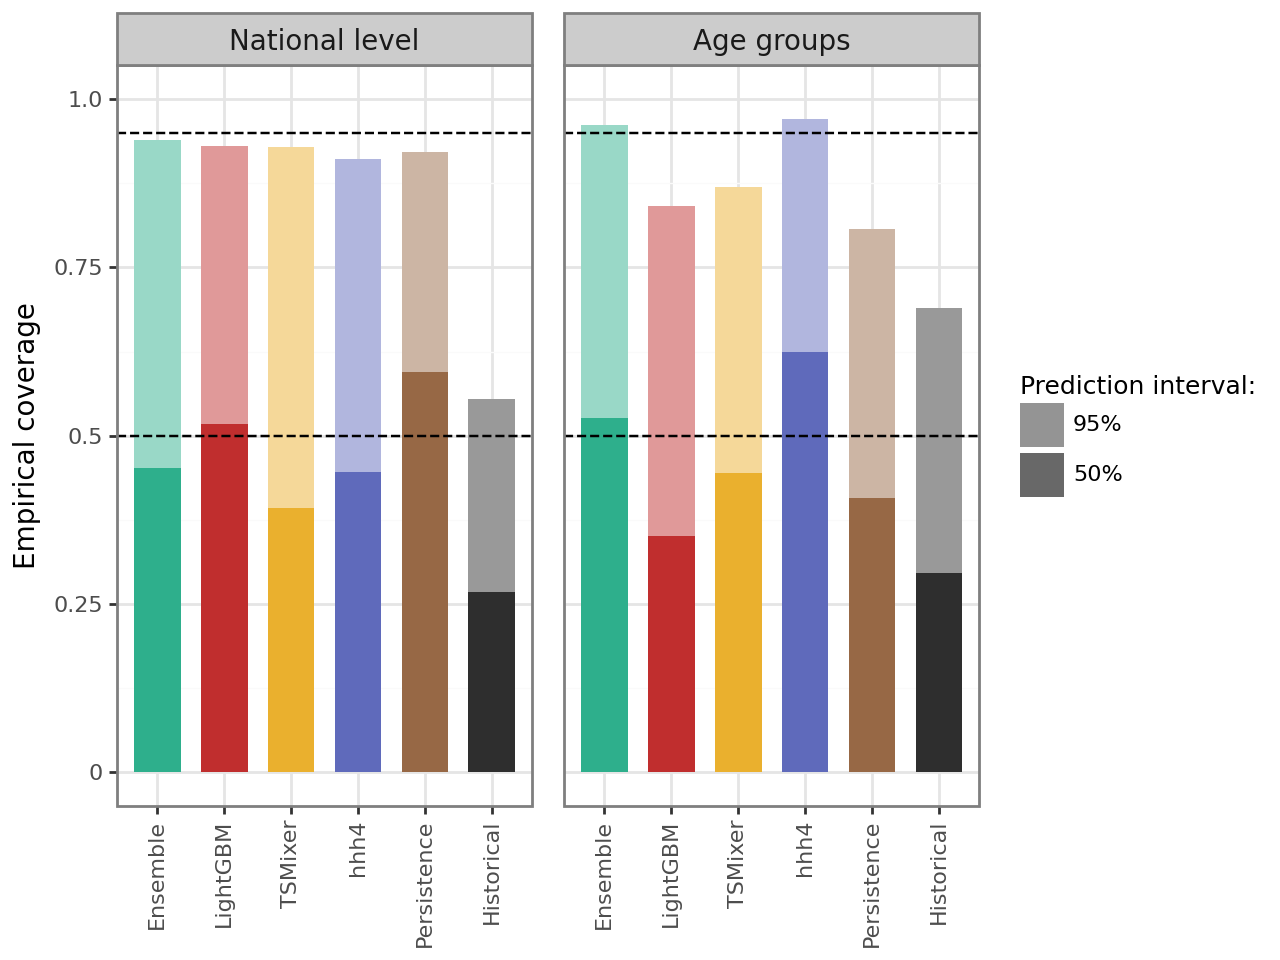

In [10]:
p = plot_coverage(df_wide, MAIN_MODELS)
p.show()

In [11]:
p.save(ROOT / "figures" / "coverage.pdf", width=160, height=70, units="mm", dpi=600, verbose=False)

## By age group

In [12]:
def plot_scores_by_age_group(scores, models=None):
    if models is not None:
        scores = scores[scores.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in scores.model.unique()]
    scores["model"] = pd.Categorical(scores["model"], categories=model_order, ordered=True)

    plot = (
        ggplot()
        + geom_point(
            scores[scores.metric == "ae"],
            aes(x="model", y="value", fill="model"),
            shape="D",
            show_legend=False,
        )
        + geom_bar(
            scores[scores.metric == "wis"],
            aes(x="model", y="value", color="model"),
            fill="white",
            stat="identity",
            width=0.7,
            show_legend=False,
        )
        + geom_bar(
            scores[~scores.metric.isin(["wis", "ae"])],
            aes(x="model", y="value", fill="model", alpha="metric"),
            size=0.1,
            stat="identity",
            width=0.7,
            show_legend={"color": False, "fill": False, "alpha": True},
        )
        + scale_color_manual(values=MODEL_COLORS)
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_manual(
            values=WIS_ALPHA,
            labels=["Overprediction", "Spread", "Underprediction"],
            guide=guide_legend(reverse=False),
        )
        + labs(x="", y="WIS", color="Model", alpha="Decomposition\nof WIS:", title="")
        + facet_wrap("~age_group")
        + theme_bw()
        + custom_theme()
        + theme(legend_position="right", legend_title_position="top")
    )

    return plot

In [13]:
scores_age = load_scores("scores_age.csv", by_age=True, long_format=True)

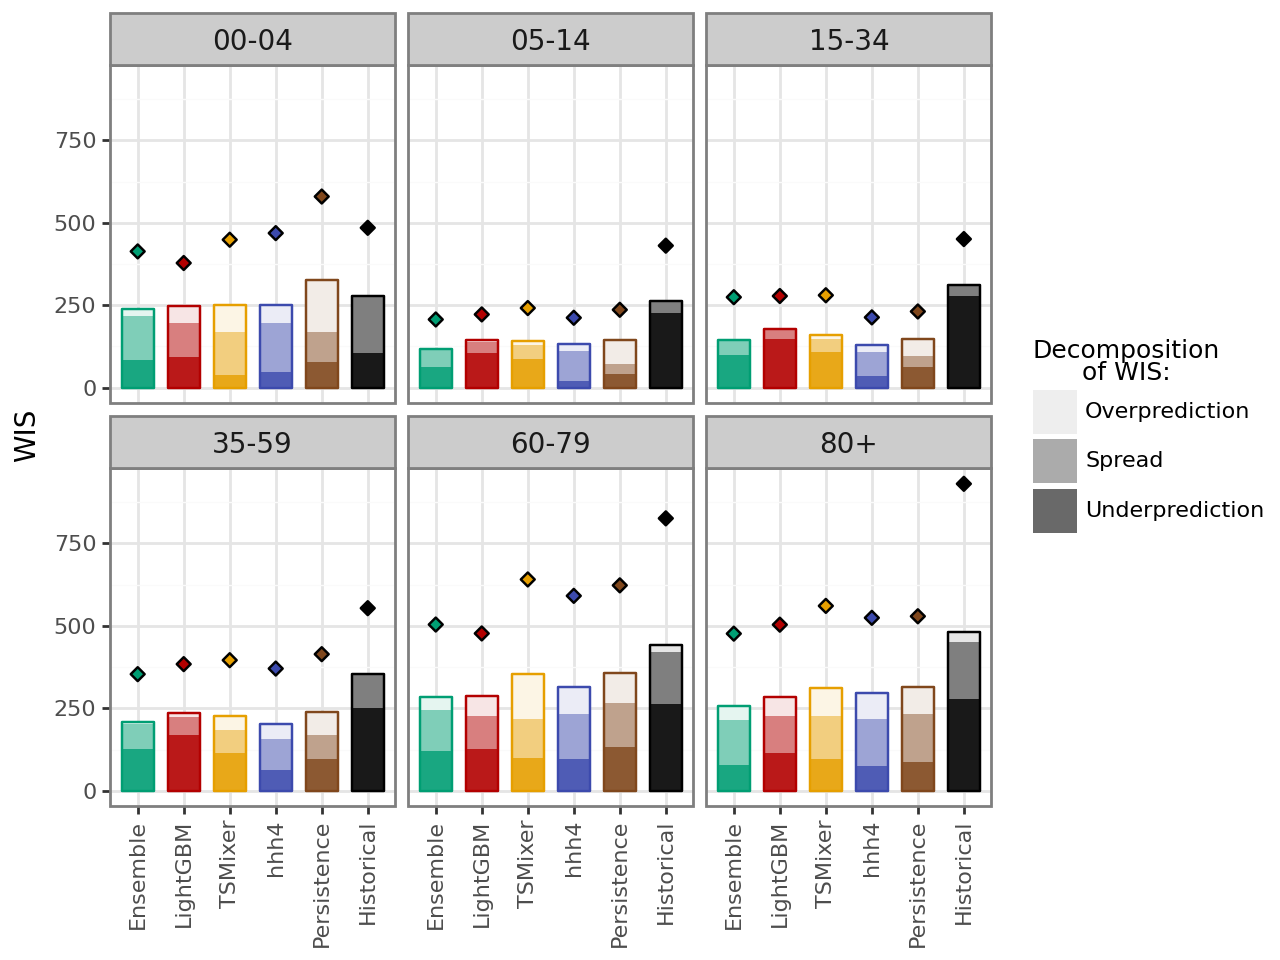

In [14]:
p = plot_scores_by_age_group(scores_age, MAIN_MODELS)
p.show()

In [15]:
p.save(ROOT / "figures" / "wis_age.pdf", width=160, height=100, units="mm", dpi=600, verbose=False)

## By horizon

In [16]:
def plot_scores_by_horizon_and_model(df, level="national", models=None):
    scores = df[df.level == level].copy()

    if models is not None:
        scores = scores[scores.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in scores.model.unique()]
    scores["model"] = pd.Categorical(scores["model"], categories=model_order, ordered=True)

    plot = (
        ggplot()
        + geom_point(
            scores[scores.metric == "ae"],
            aes(x="model", y="value", fill="model"),
            shape="D",
            show_legend=False,
        )
        + geom_bar(
            scores[scores.metric == "wis"],
            aes(x="model", y="value", color="model"),
            fill="white",
            stat="identity",
            width=0.7,
            show_legend=False,
        )
        + geom_bar(
            scores[~scores.metric.isin(["wis", "ae"])],
            aes(x="model", y="value", fill="model", alpha="metric"),
            size=0.1,
            stat="identity",
            width=0.7,
            show_legend={"color": False, "fill": False, "alpha": True},
        )
        + scale_color_manual(values=MODEL_COLORS)
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_manual(
            values=WIS_ALPHA,
            labels=["Overprediction", "Spread", "Underprediction"],
            guide=guide_legend(reverse=False),
        )
        + labs(
            x="",
            y="WIS",
            color="Model",
            alpha="Decomposition of WIS:",
            title="WIS by horizon",
        )
        + facet_grid(cols="horizon", scales="free", space="free")
        + theme_bw()
        + custom_theme()
        + theme(
            legend_position="bottom",
            legend_title_position="left",
        )
    )

    return plot

In [17]:
scores_horizon = load_scores("scores_horizon.csv", by_horizon=True, long_format=True)

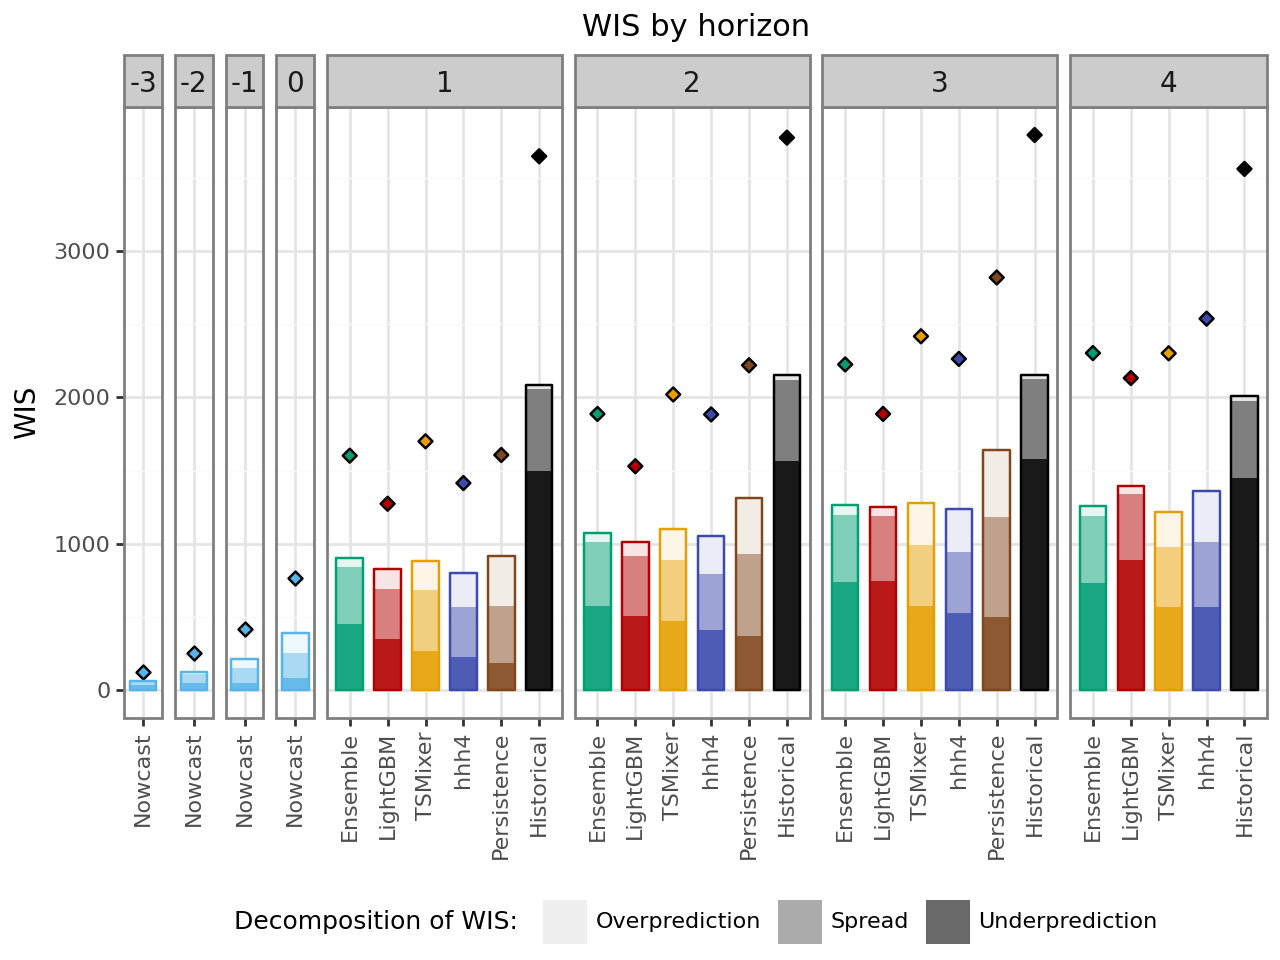

In [18]:
p = plot_scores_by_horizon_and_model(scores_horizon, "national", ["Nowcast"] + MAIN_MODELS)
p.show()

In [19]:
p.save(
    ROOT / "figures" / "wis_national_horizon.pdf",
    width=170,
    height=100,
    units="mm",
    dpi=600,
    verbose=False,
)

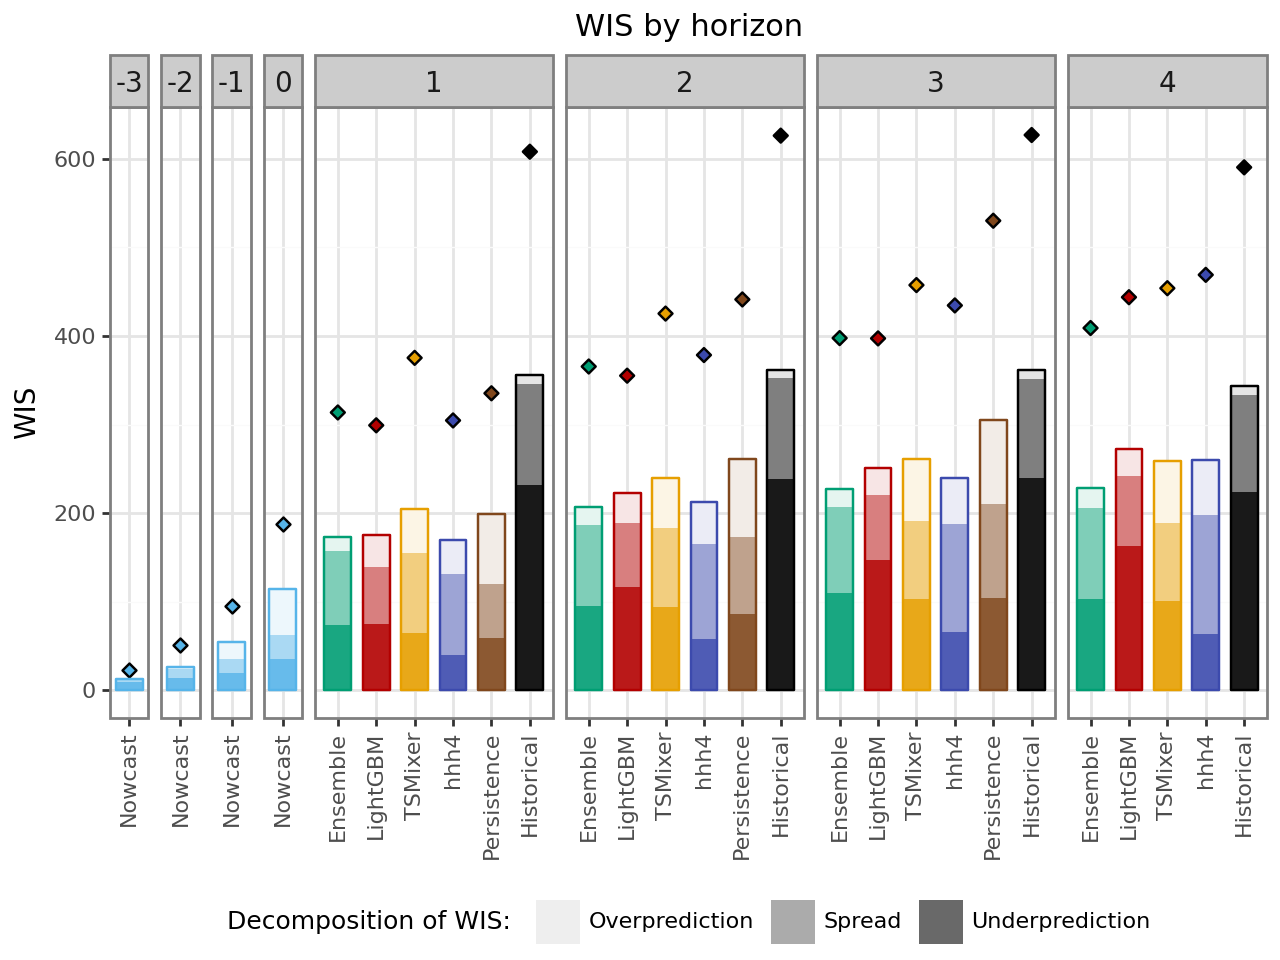

In [20]:
p = plot_scores_by_horizon_and_model(scores_horizon, "age", ["Nowcast"] + MAIN_MODELS)
p.show()

In [21]:
p.save(
    ROOT / "figures" / "wis_age_horizon.pdf",
    width=170,
    height=100,
    units="mm",
    dpi=600,
    verbose=False,
)

# Coverage by horizon

In [22]:
def plot_coverage_by_horizon(df_wide, level="national", models=None):
    df_wide = df_wide[df_wide.level == level].copy()

    if models is not None:
        df_wide = df_wide[df_wide.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in df_wide.model.unique()]
    df_wide["model"] = pd.Categorical(df_wide["model"], categories=model_order, ordered=True)

    alphas = {"50%": 0.7, "95%": 0.4}

    p = (
        ggplot(df_wide, aes(x="model"))
        + facet_wrap(
            "~level",
            nrow=1,
            scales="fixed",
            labeller=lambda x: ("National level" if x == "national" else "Age groups"),
        )
        + expand_limits(y=1)
        + geom_col(aes(y="c95"), width=0.7, fill="white", show_legend={"fill": False})
        + geom_col(
            aes(y="c95", fill="model", alpha='"95%"'),
            width=0.7,
            show_legend={"fill": False},
        )
        + geom_col(
            aes(y="c50", fill="model", alpha='"50%"'),
            width=0.7,
            show_legend={"fill": False},
        )
        + geom_hline(yintercept=[0.5, 0.95], linetype="dashed")
        + scale_y_continuous(labels=lambda y: ["0" if val == 0 else val for val in y])
        + labs(
            x="",
            y="Empirical coverage",
            color="Model",
            alpha="Prediction interval: ",
            title="Coverage by horizon",
        )
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_manual(values=alphas, guide=guide_legend(reverse=True))
        + facet_grid(cols="horizon", scales="free", space="free")
        + theme_bw()
        + custom_theme()
        + theme(
            legend_position="bottom",
            legend_title_position="left",
        )
    )

    return p

In [23]:
scores_horizon = load_scores("scores_horizon.csv", by_horizon=True)

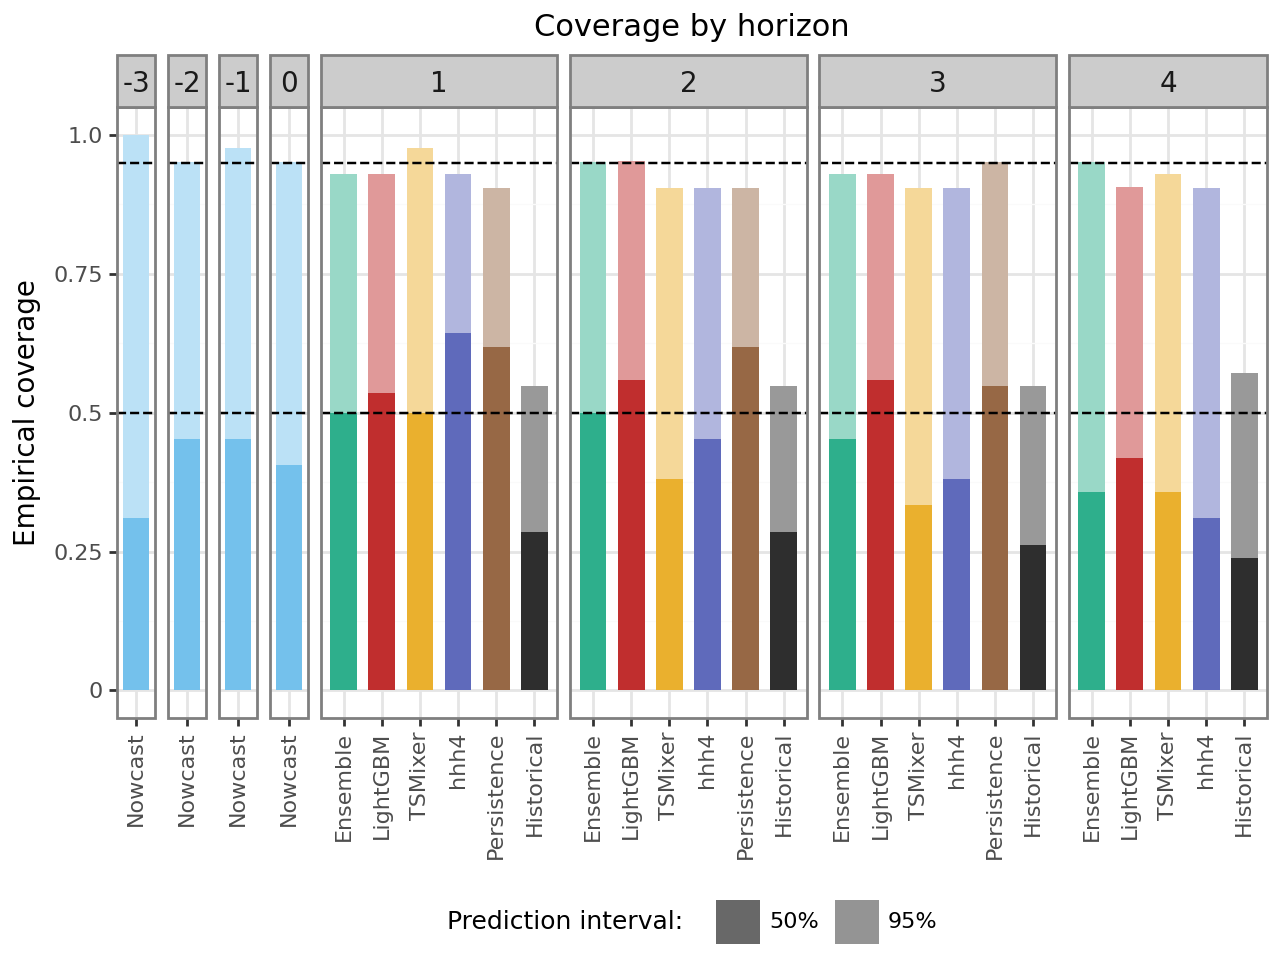

In [24]:
p = plot_coverage_by_horizon(scores_horizon, "national", ["Nowcast"] + MAIN_MODELS)
p.show()

In [25]:
p.save(
    ROOT / "figures" / "coverage_national_horizon.pdf",
    width=170,
    height=100,
    units="mm",
    dpi=600,
    verbose=False,
)

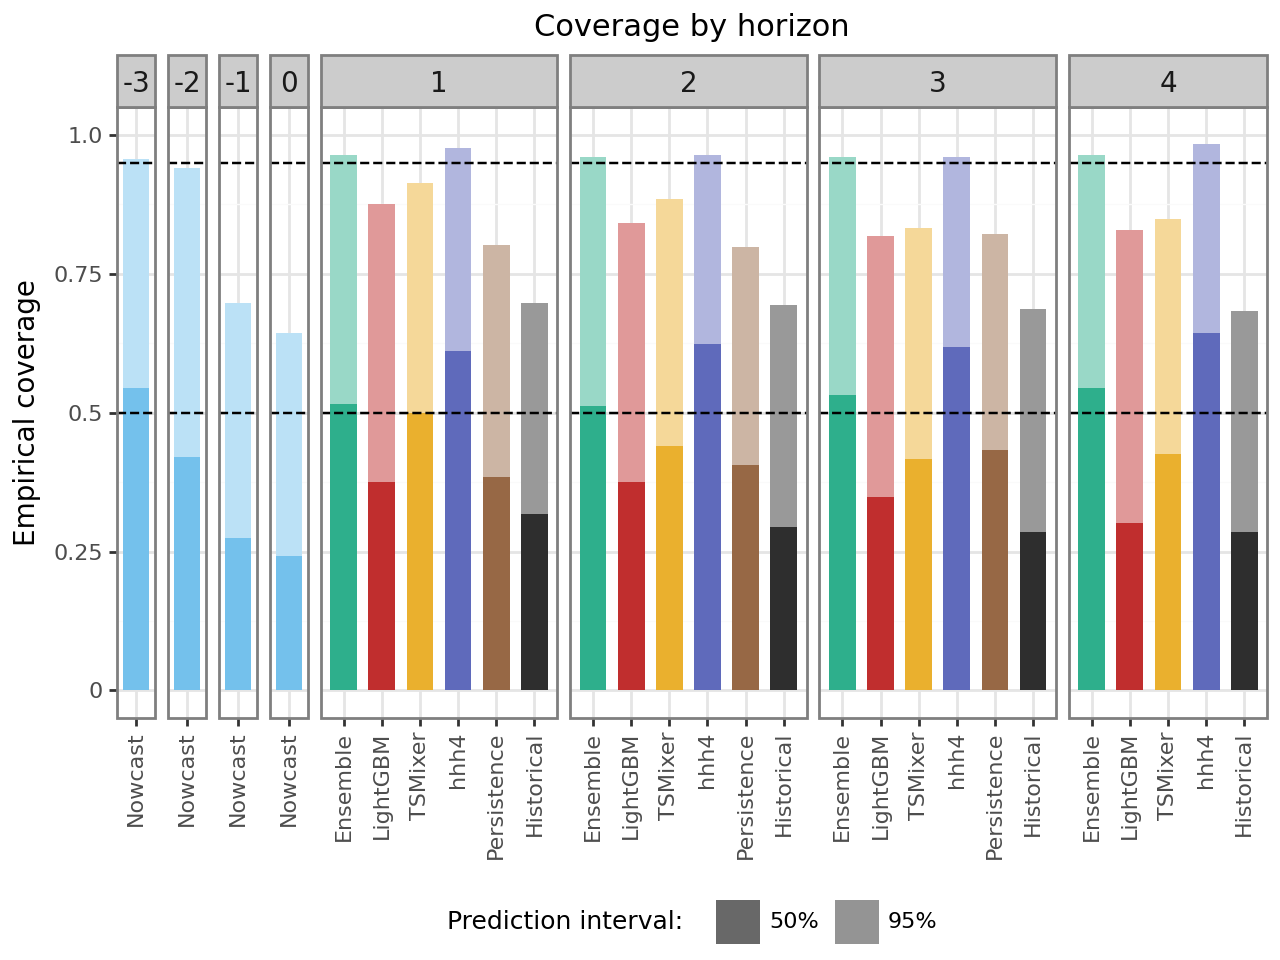

In [26]:
p = plot_coverage_by_horizon(scores_horizon, "age", ["Nowcast"] + MAIN_MODELS)
p.show()

In [27]:
p.save(
    ROOT / "figures" / "coverage_age_horizon.pdf",
    width=170,
    height=100,
    units="mm",
    dpi=600,
    verbose=False,
)

# Compare model variants

In [28]:
scores_long = load_scores("scores.csv", long_format=True)

In [29]:
scores_long.model.unique()

array(['Nowcast', 'hhh4-Oracle', 'LightGBM-NoCovariates', 'hhh4-Discard',
       'LightGBM-NoCovid', 'TSMixer-Discard', 'LightGBM-Discard', 'hhh4',
       'hhh4-Shuffle', 'TSMixer', 'LightGBM', 'hhh4-Vincentization',
       'Ensemble', 'LightGBM-Oracle', 'TSMixer-Oracle',
       'TSCount-Extended', 'hhh4-NoCovid', 'TSMixer-NoCovid',
       'Persistence', 'TSMixer-Naive', 'TSMixer-Covariates', 'hhh4-Naive',
       'LightGBM-Naive', 'TSCount-Simple', 'Historical'], dtype=object)

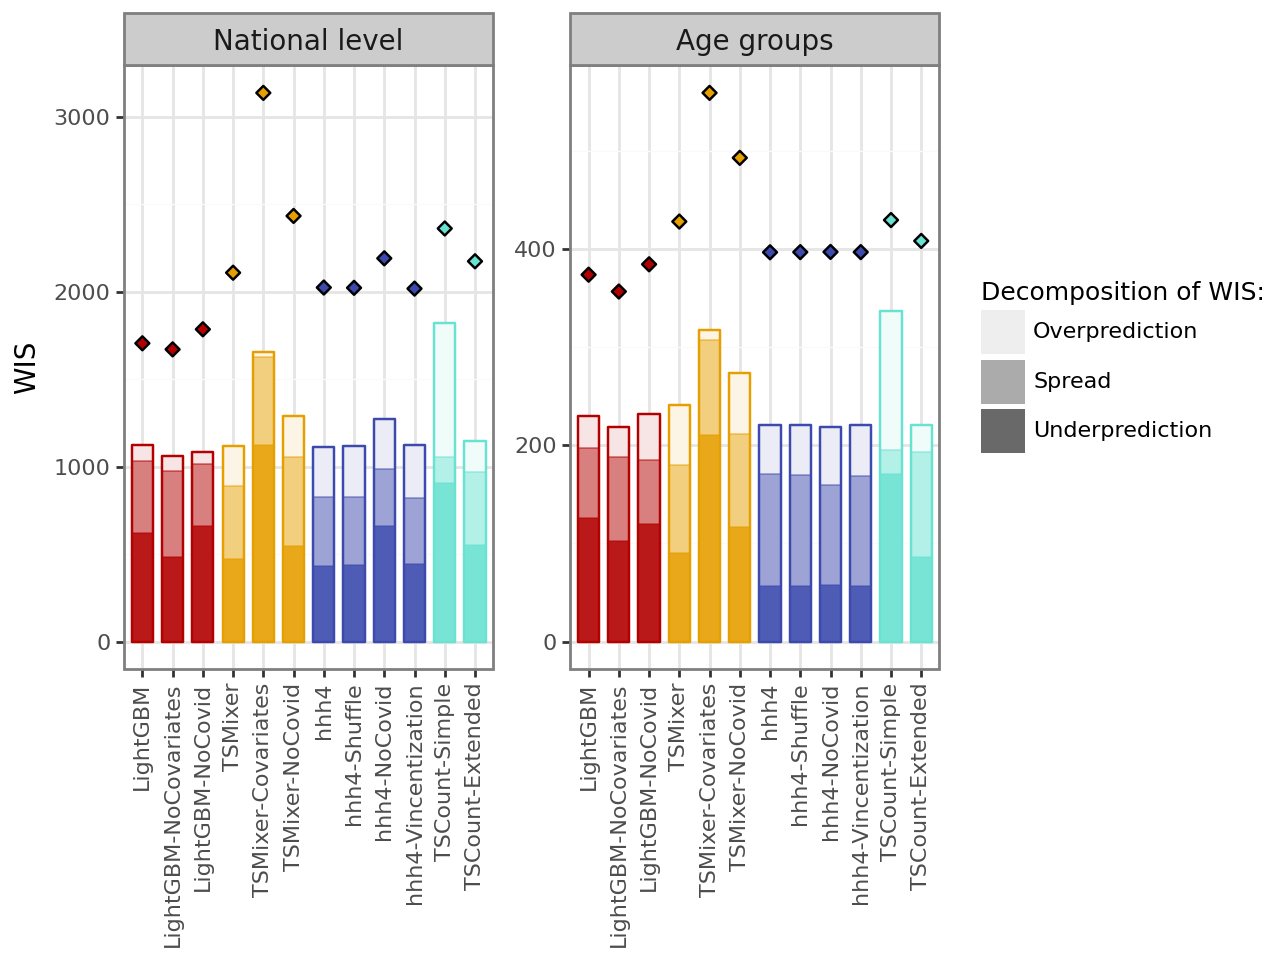

In [30]:
p = plot_total_scores(
    scores_long,
    models=[
        "LightGBM",
        "LightGBM-NoCovariates",
        "LightGBM-NoCovid",
        "TSMixer",
        "TSMixer-Covariates",
        "TSMixer-NoCovid",
        "hhh4",
        "hhh4-Shuffle",
        "hhh4-NoCovid",
        "hhh4-Vincentization",
        "TSCount-Simple",
        "TSCount-Extended",
    ],
)
p.show()

In [31]:
p.save(
    ROOT / "figures" / "wis_model_variants.pdf",
    width=160,
    height=80,
    units="mm",
    dpi=600,
    verbose=False,
)

# Variants by horizon

In [32]:
def plot_variants_by_horizon(df, level="national", models=None, ymax="auto"):
    scores = df[df.level == level].copy()

    if models is not None:
        scores = scores[scores.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in scores.model.unique()]
    scores["model"] = pd.Categorical(scores["model"], categories=model_order, ordered=True)

    if ymax == "auto":
        ymax = scores.value.max() * 1.05

    plot = (
        ggplot()
        + geom_point(
            scores[scores.metric == "ae"],
            aes(x="variant", y="value", fill="model"),
            shape="D",
            show_legend=False,
        )
        + geom_bar(
            scores[scores.metric == "wis"],
            aes(x="variant", y="value", color="model"),
            fill="white",
            stat="identity",
            width=0.7,
            show_legend=False,
        )
        + geom_bar(
            scores[~scores.metric.isin(["wis", "ae"])],
            aes(x="variant", y="value", fill="model", alpha="metric"),
            size=0.1,
            stat="identity",
            width=0.7,
            show_legend={"color": False, "fill": False, "alpha": True},
        )
        + scale_color_manual(values=MODEL_COLORS)
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_manual(
            values=WIS_ALPHA,
            labels=["Overprediction", "Spread", "Underprediction"],
            guide=guide_legend(reverse=False),
        )
        + labs(
            x="",
            y="WIS",
            color="Model",
            alpha="Decomposition of WIS:",
            title="WIS by horizon",
        )
        + facet_grid(cols="horizon", rows="class", scales="free", space="free")  # Create a facet for each horizon
        + theme_bw()
        + custom_theme()
        + theme(
            legend_position="bottom",
            legend_title_position="left",
        )
        + ylim(0, ymax)
    )

    return plot

In [33]:
df_long = load_scores("scores_horizon.csv", by_horizon=True, long_format=True)

In [34]:
df_long["class"] = df_long.model.apply(lambda x: x.split("-")[0])
df_long["variant"] = df_long.model.apply(lambda x: x.split("-")[-1])
df_long.variant = df_long.variant.replace({"LightGBM": "Coupling", "TSMixer": "Coupling", "hhh4": "Coupling"})
df_long["variant"] = pd.Categorical(
    df_long["variant"],
    categories=[
        "Nowcast",
        "Coupling",
        "NoCovariates",
        "NoCovid",
        "Oracle",
        "Discard",
        "Naive",
        "Ensemble",
        "Persistence",
        "Historical",
    ],
    ordered=True,
)


df_now = df_long[df_long.model == "Nowcast"].copy()

for c in ["LightGBM", "TSMixer", "hhh4"]:
    df_now["class"] = c
    df_long = pd.concat([df_long, df_now])

df_long = df_long[df_long["class"] != "Nowcast"]
df_long = df_long[df_long.horizon >= 0].copy()

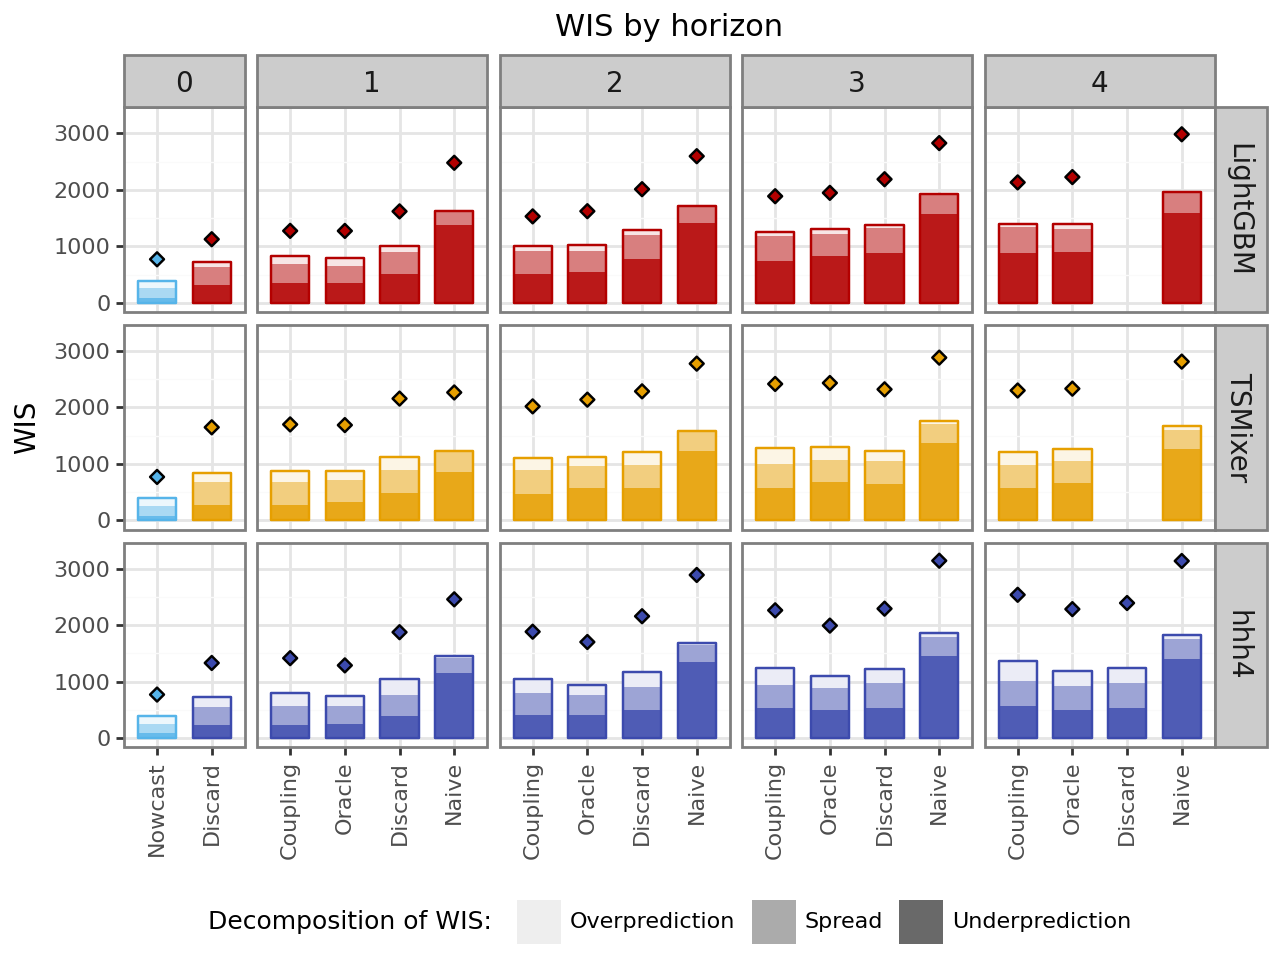

In [35]:
p = plot_variants_by_horizon(
    df_long,
    "national",
    [
        "LightGBM",
        "LightGBM-Oracle",
        "LightGBM-Discard",
        "LightGBM-Naive",
        "TSMixer",
        "TSMixer-Oracle",
        "TSMixer-Discard",
        "TSMixer-Naive",
        "hhh4",
        "hhh4-Oracle",
        "hhh4-Discard",
        "hhh4-Naive",
        "Nowcast",
    ],
)
p.show()

In [36]:
p.save(
    ROOT / "figures" / "wis_variants_horizon.pdf",
    width=130,
    height=100,
    units="mm",
    dpi=600,
    verbose=False,
)

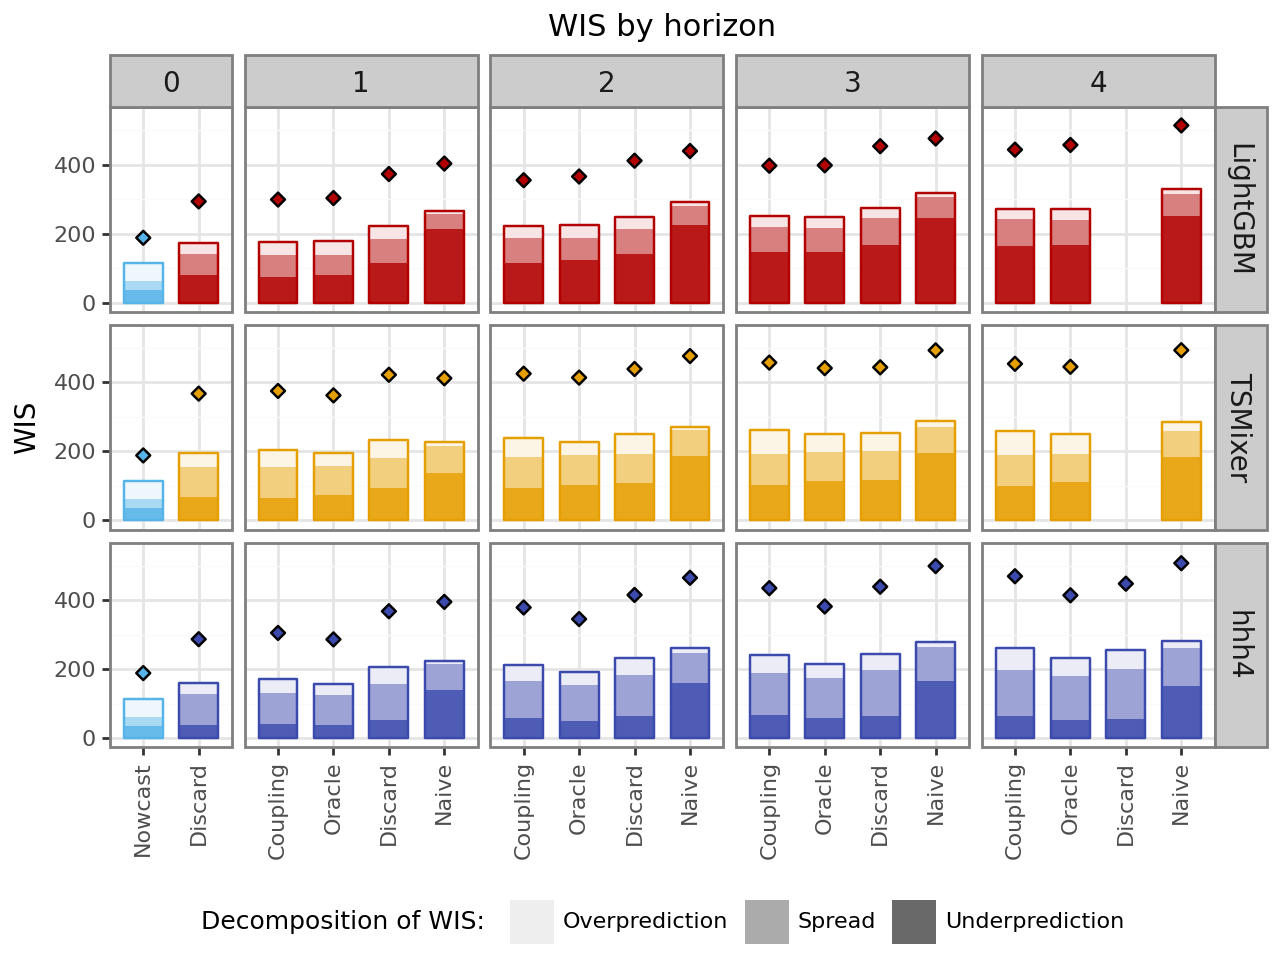

In [37]:
p = plot_variants_by_horizon(
    df_long,
    "age",
    [
        "LightGBM",
        "LightGBM-Oracle",
        "LightGBM-Discard",
        "LightGBM-Naive",
        "TSMixer",
        "TSMixer-Oracle",
        "TSMixer-Discard",
        "TSMixer-Naive",
        "hhh4",
        "hhh4-Oracle",
        "hhh4-Discard",
        "hhh4-Naive",
        "Nowcast",
    ],
)
p.show()

In [38]:
p.save(
    ROOT / "figures" / "wis_variants_horizon_age.pdf",
    width=130,
    height=100,
    units="mm",
    dpi=600,
    verbose=False,
)